In [43]:
# Step 1: Importing packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Optional: %pip install xgboost, %pip install wordcloud

In [5]:
# Step 2: Importing Amazon Alexa Dataset and displaying records
data = pd.read_csv(r"C:\Users\sam\Desktop\amazon_alexa.tsv", delimiter='\t', quoting=3)

# Step 3: Display top records and structure of dataset
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [11]:
data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [13]:
# data.isnull().any()
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [15]:
# Step 4: Handling missing values in 'verified_reviews' column
data['verified_reviews'] = data['verified_reviews'].fillna('Missing a lot of this kinda os scene or cinema. Would love to do it right someday')


In [ ]:
# Step 5: Add a column for review length
data['length'] = data['verified_reviews'].apply(len)

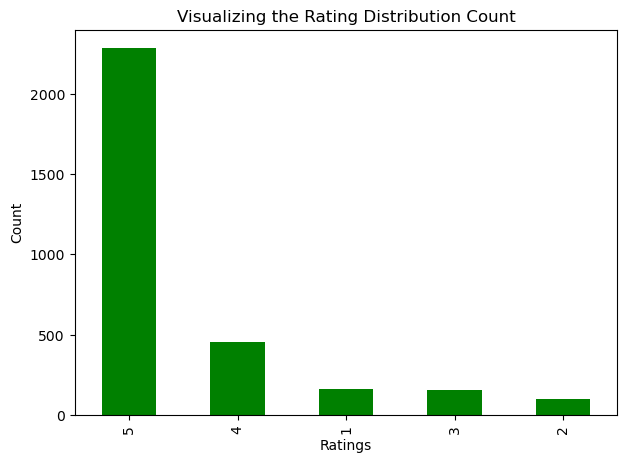

In [17]:
# Step 6: Visualizing ratings distribution
plt.figure(figsize=(7,5))
data['rating'].value_counts().plot.bar(color='green')
plt.title('Visualizing the Rating Distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [19]:
# Step 7: Pie chart for rating distribution
labels = ['5', '4', '3', '2', '1']
sizes = data['rating'].value_counts().values
colors = ['green', 'magenta', 'pink', 'yellow', 'red']
explode = [0.01] * 5    # [0.001, 0.001, 0.001, 0.001, 0.001]

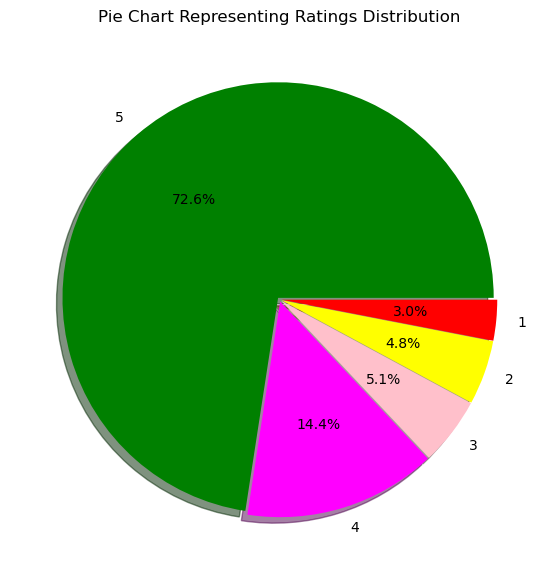

In [21]:
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, shadow=True, autopct="%1.1f%%")
plt.title('Pie Chart Representing Ratings Distribution')
plt.show()

In [23]:
# Step 8: Converting date column to datetime
data['date'] = pd.to_datetime(data['date'])

C:\Users\sam\AppData\Local\Temp\ipykernel_11176\2833588940.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


In [25]:
# Step 9: Display minimum and maximum date
print(f"Minimum date: {data['date'].min()}")
print(f"Maximum date: {data['date'].max()}")

Minimum date: 2018-05-16 00:00:00
Maximum date: 2018-07-31 00:00:00


In [27]:
# Display year
data['date'].dt.year.value_counts()

date
2018    3150
Name: count, dtype: int64

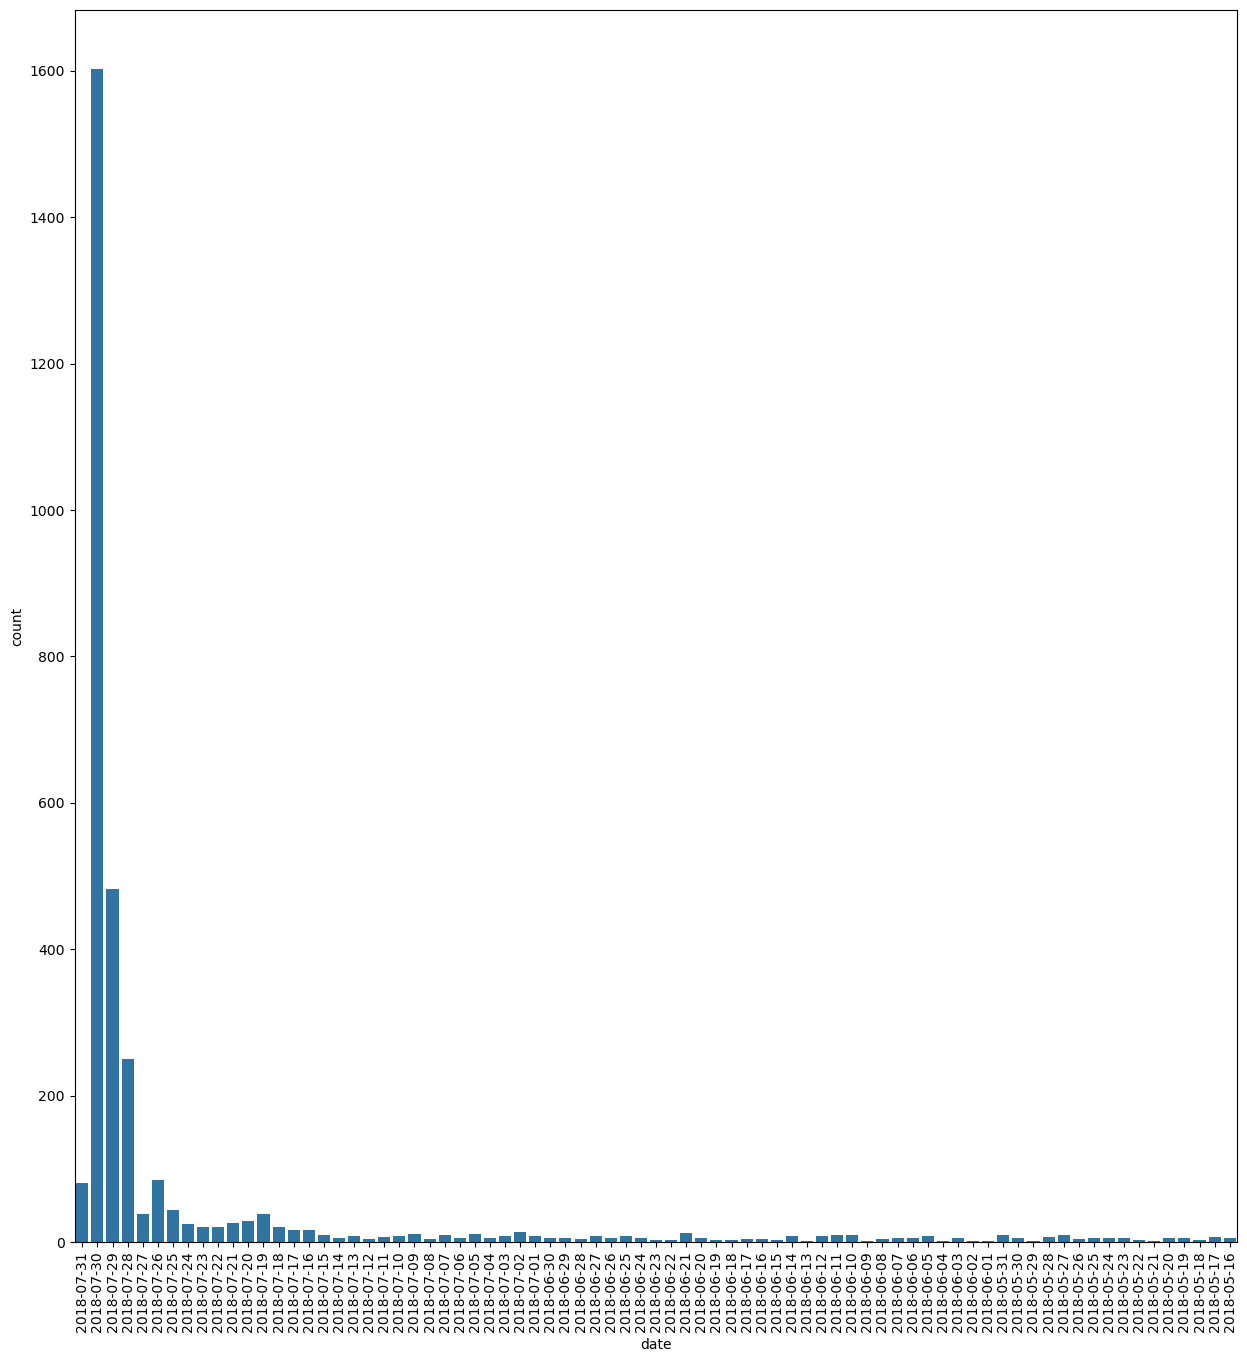

In [35]:
# Displaying data graphically
plt.figure(figsize=(15,16))
sns.countplot(x='date',data=data)
plt.xticks(rotation=90)
plt.show();

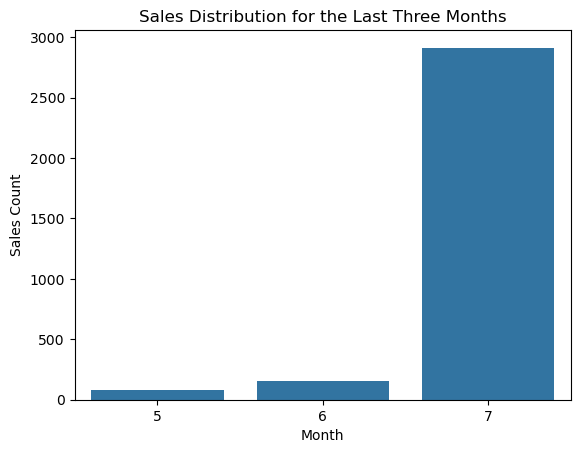

In [39]:
# 10  Displaying three months sales in numbers
data['date'].dt.month.value_counts()

# Calculate the offset for the last 3 months

# Step 10: Display sales count for last three months
# last_three_months = data['date'] >= pd.Timestamp.today() - pd.DateOffset(months=3)
# df_filtered = data[last_three_months]

offset = pd.DateOffset(months=3)

# Filter for dates within the last 3 months (excluding today)
last_three_months = data['date'] >= pd.Timestamp.today() - offset

# Filter the DataFrame
df_filtered = data[last_three_months]

# Create the countplot
sns.countplot(x=data['date'].dt.month, data=df_filtered)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales Count')
plt.title('Sales Distribution for the Last Three Months')

# Show the plot
plt.show()

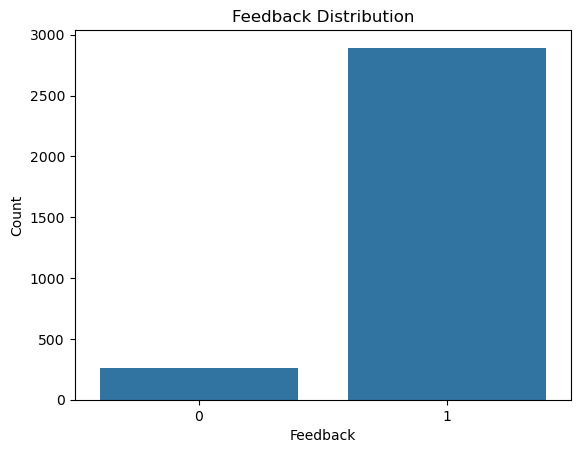

In [33]:
# Step 11: Plot feedback distribution and bar chart
sns.countplot(x='feedback', data=data)
plt.title('Feedback Distribution')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()


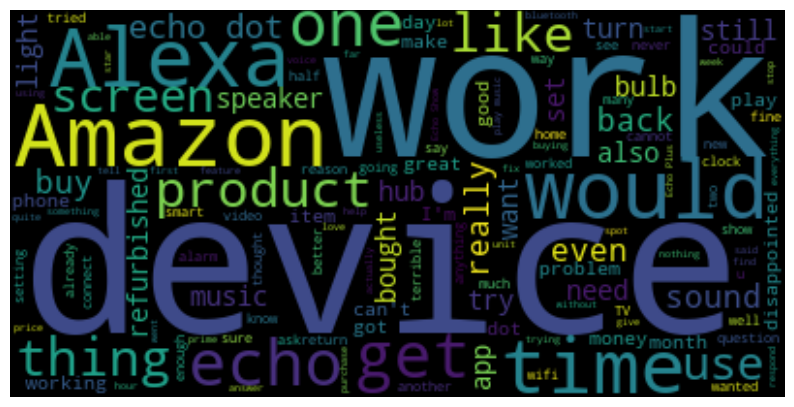

In [45]:
# Step 12: WordCloud generation for negative reviews
neg_reviews = " ".join(data[data['feedback'] == 0]['verified_reviews'].values)
wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS).generate(neg_reviews)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [47]:
# Step 13: Preprocessing text and generating the Bag of Words
corpus = []
stemmer = PorterStemmer()
for i in range(len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews']).lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    corpus.append(' '.join(review))

# Using CountVectorizer to create a Bag of Words
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

# Saving the CountVectorizer as a pickle
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))


In [49]:
# Step 14: Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

In [51]:
# Step 15: Feature scaling
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# Saving the scaler as a pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [53]:
# Step 16: Training a Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=15)
rf_clf.fit(X_train_scl, y_train)

RandomForestClassifier(random_state=15)

In [55]:
# Step 17: Evaluating the model
y_pred = rf_clf.predict(X_test_scl)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9365079365079365


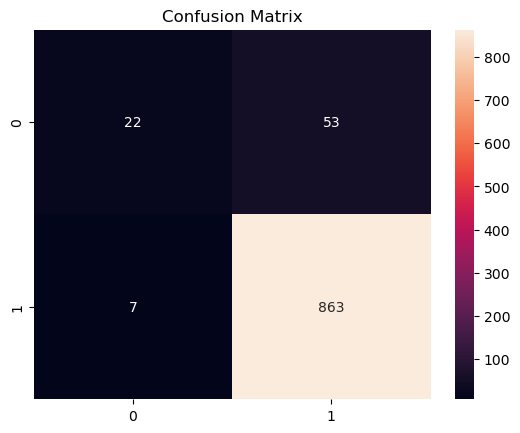

In [57]:
# Step 18: Confusion matrix display
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [59]:
# Step 19: Cross-validation score
cv_scores = cross_val_score(rf_clf, X_train_scl, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")

Cross-validation scores: [0.93424036 0.93877551 0.92743764 0.93877551 0.93650794]
Mean CV score: 0.9351473922902495


In [61]:
# Step 20: Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3)
grid_search.fit(X_train_scl, y_train)

print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
